In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np

num_villes = 5000
num_clients = num_villes - 1  # Exclure le dépôt

def generate_weighted_adjacency_matrix(n):
    adjacency_matrix = np.random.rand(n, n)  # Générer une matrice aléatoire entre 0 et 1
    adjacency_matrix *= 100  # Multiplier par une valeur maximale pour représenter les poids des distances
    adjacency_matrix = np.round(adjacency_matrix).astype(int)  # Arrondir les valeurs et les convertir en entiers
    np.fill_diagonal(adjacency_matrix, 0)  # Remplir les diagonales avec des zéros pour représenter les distances de la ville à elle-même
    adjacency_matrix = np.where(adjacency_matrix == 0, 0, adjacency_matrix)  # Remplacer les valeurs non nulles par des zéros
    return adjacency_matrix

matrice = generate_weighted_adjacency_matrix(num_villes)
print(matrice)


[[ 0  7 83 ... 82 49 23]
 [ 1  0 86 ... 83 97 70]
 [16 92  0 ... 28 69 37]
 ...
 [ 9 48  8 ...  0 51 15]
 [92 68 19 ... 85  0 68]
 [38 41 88 ... 15 56  0]]


In [57]:
import numpy as np
from numpy.random import choice as np_choice

# Évaluer la qualité des solutions
def calculer_distance_total(solution, matrice):
    distances = matrice[solution[:-1], solution[1:]]
    return np.sum(distances)

def maj_pheromone(matrice_pheromone, routes, distances):
    evaporation = 0.5

    # Évaporation des phéromones   
    matrice_pheromone *= (1 - evaporation)

    # Dépôt de phéromones sur les meilleures routes
    for route, distance in zip(routes, distances):
        pheromones = Q / distance
        matrice_pheromone[route[:-1], route[1:]] += pheromones

def maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite):
    for route in routes_visitees:
        for i in range(len(route) - 1):
            ville_actuelle = route[i]
            ville_suivante = route[i + 1]
            matrice_pheromone[ville_actuelle, ville_suivante] += intensite

def selectionner_ville(matrice_pheromone, current_ville, ville_non_visitee, alpha, beta):

    pheromone = matrice_pheromone[current_ville, ville_non_visitee]
    
    distance = matrice[current_ville, ville_non_visitee]

    proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)

    proba[distance == 0] = 0  # Gérer les distances nulles
    
    total_proba = np.sum(proba)
    if total_proba == 0:
        proba = np.ones(len(proba)) / len(proba)
    else:
        proba /= total_proba

    proba = np.maximum(proba, 0)

    next_ville_index = np_choice(len(ville_non_visitee), p=proba)
    next_ville = ville_non_visitee[next_ville_index]

    return next_ville

def vrp(matrice, num_fourmis, num_iterations, alpha, beta):
    num_ville = len(matrice)
    matrice_pheromone = np.ones((num_ville, num_ville))  # Matrice des phéromones
    best_route = None
    best_distance = float('inf')

    for i in range(num_iterations):
        routes_visitees = []  # Routes visitées par les fourmis
        routes = []
        distances = []

        for j in range(num_fourmis):
            route = [0]  # Dépôt initial
            ville_non_visitees = np.arange(1, num_ville)  # Villes non visitées
            while ville_non_visitees.size > 0:
                current_ville = route[-1]
                next_ville = selectionner_ville(matrice_pheromone, current_ville, ville_non_visitees, alpha, beta)
                route.append(next_ville)
                ville_non_visitees = np.delete(ville_non_visitees, np.where(ville_non_visitees == next_ville))

            route.append(0)  # Retour au dépôt

            if ville_non_visitees.size == 0 and route[-1] == 0:
                distance = calculer_distance_total(route, matrice)
                routes.append(route)
                distances.append(distance)

                if distance < best_distance:
                    best_route = route
                    best_distance = distance

                routes_visitees.append(route)

        maj_pheromone(matrice_pheromone, routes, distances)
        maj_pheromone_intensification(matrice_pheromone, routes_visitees, intensite)  # Intensification de la matrice de phéromone

    return best_route, best_distance

# On répartit entre le nombre de camions
def repartir_routes_optimal(route, num_camions):
    villes = route[1:-1]  # Liste des villes à répartir (excluant le dépôt)
    num_villes = len(villes)

    # Calcul de la distance totale de la route
    distance_totale = calculer_distance_total(route, matrice)

    # Calcul de la distance moyenne par camion
    distance_moyenne = distance_totale / num_camions

    camions_routes = []
    longueurs_routes = []

    camion_route = [0]  # Dépôt initial
    longueur_route = 0

    for i in range(num_villes):
        ville = villes[i]
        ville_suivante = villes[i + 1] if i < num_villes - 1 else 0  # Prochaine ville ou retour au dépôt

        # Ajout de la ville à la route actuelle
        camion_route.append(ville)
        longueur_route += matrice[ville][ville_suivante]

        # Si la longueur de la route actuelle dépasse la distance moyenne, on la termine et on commence une nouvelle route
        if longueur_route > distance_moyenne:
            camion_route.append(0)  # Retour au dépôt
            camions_routes.append(camion_route)
            longueurs_routes.append(longueur_route)

            camion_route = [0]  # Nouvelle route avec le dépôt initial
            longueur_route = 0

    # Ajout de la dernière route incomplète
    camion_route.append(0)  # Retour au dépôt
    camions_routes.append(camion_route)
    longueurs_routes.append(longueur_route)

    return camions_routes, longueurs_routes

# Paramètres de l'ACO
num_fourmis = 3
num_iterations = 15
alpha = 1.0  # Influence de la phéromone
beta = 5.0  # Influence de la visibilité   
Q = 100  # Quantité de phéromone déposée par les fourmis
intensite = 1.7 #intensification des pheromones
num_camions = 3  # Quantité de camions

best_route, best_distance = vrp(matrice, num_fourmis, num_iterations, alpha, beta)
camions_routes, longueurs_routes = repartir_routes_optimal(best_route, num_camions)

print("|-----------------Meilleur Global-----------------|")
print("Meilleure route:", best_route)
print("Distance totale:", best_distance)
print("|---------------Meilleur par camion---------------|")

# Affichage des routes assignées à chaque camion et de la longueur totale de chaque route
for i, route in enumerate(camions_routes):
    print(f"|------------------------{i+1}------------------------|")
    print(f"Camion {i+1} - Route : {route} ")
    print(f"Distance totale : {longueurs_routes[i]}")
    

C:\Users\Theo\AppData\Local\Temp\ipykernel_6420\2608385751.py:34: RuntimeWarning: divide by zero encountered in divide
  proba = (pheromone ** alpha * (1.0 / distance) ** beta).astype(float)


|-----------------Meilleur Global-----------------|
Meilleure route: [0, 3078, 727, 4036, 3094, 3072, 3496, 229, 3735, 2934, 3433, 2658, 2169, 1866, 4124, 4689, 1716, 4722, 2428, 3845, 4096, 3992, 2435, 4723, 1462, 1983, 2346, 4645, 2449, 2306, 581, 4979, 2304, 2910, 2534, 3281, 2533, 2653, 2004, 427, 4754, 2740, 1751, 1984, 864, 2848, 4926, 3357, 868, 1309, 2483, 4694, 588, 4140, 546, 3776, 4547, 4100, 3399, 2659, 4737, 37, 2647, 871, 3828, 2433, 1369, 2610, 3618, 4551, 948, 1365, 2364, 4887, 1757, 2464, 372, 3884, 3681, 3466, 2869, 4679, 185, 3647, 1277, 34, 3669, 2011, 2034, 4370, 4965, 1414, 2485, 2984, 4576, 7, 4235, 2121, 1287, 2098, 240, 1870, 3896, 4819, 636, 3989, 4767, 1185, 3755, 3308, 4313, 2616, 2251, 2016, 113, 3231, 345, 1543, 384, 1633, 4560, 1573, 3814, 4119, 4621, 4001, 4371, 12, 2770, 4665, 4495, 1267, 3789, 1814, 872, 2463, 4784, 2768, 943, 3056, 2954, 2301, 3435, 2699, 3622, 463, 4697, 3182, 3612, 3236, 4489, 3506, 2124, 2528, 4741, 618, 3401, 1325, 1761, 4991, 982

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


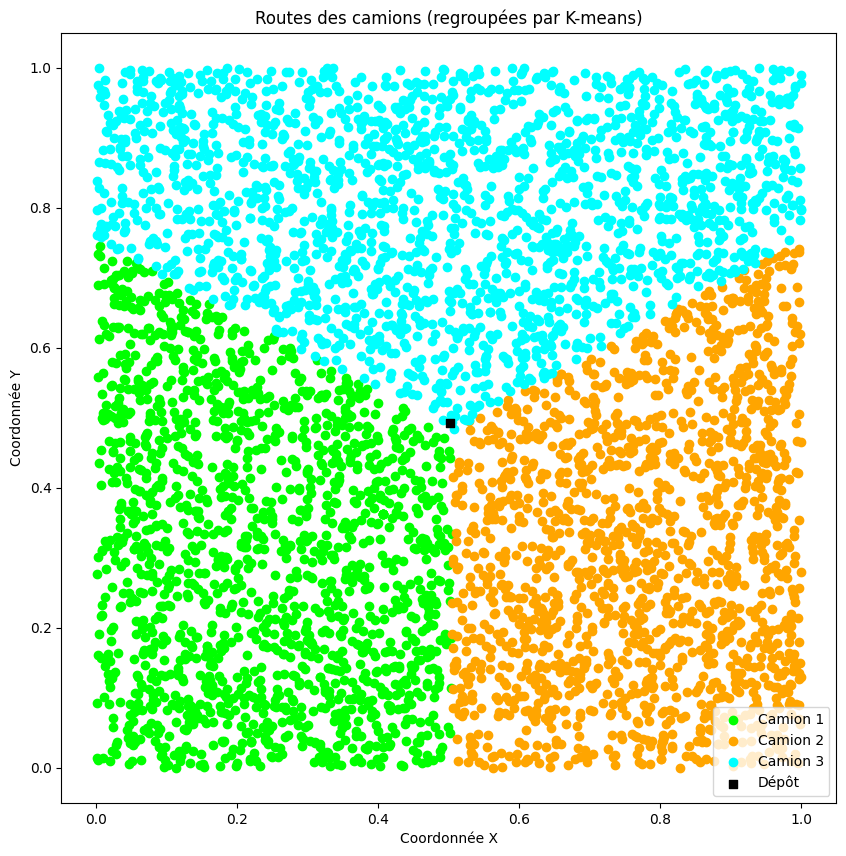

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Définition des couleurs pour chaque camion
colors = ['lime', 'orange', 'cyan', 'lime', 'yellow', 'orange', 'pink']

# Génération de coordonnées aléatoires pour chaque ville
coord_villes = np.random.rand(num_villes, 2)

# Création des clusters pour chaque route de camion
clusters = [[] for _ in range(num_camions)]

for i, route in enumerate(camions_routes):
    cluster = clusters[i]
    for ville in route:
        coord = coord_villes[ville]
        cluster.append(coord)

# Coordonnées des centres de chaque cluster
cluster_centers = [np.mean(cluster, axis=0) for cluster in clusters]

# Coordonnées du dépôt initial (centre des centres)
depot_coord = np.mean(cluster_centers, axis=0)

# Concaténation des coordonnées des points pour l'algorithme K-means
points = np.concatenate(clusters)

# Nombre de clusters (basé sur le nombre de camions)
num_clusters = num_camions

# Application de l'algorithme K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(points)

# Création du graphique
plt.figure(figsize=(10, 10))

# Parcours des points par label de cluster
for label in range(num_clusters):
    # Filtre des points pour le cluster actuel
    cluster_points = points[labels == label]

    # Récupération des coordonnées x et y pour chaque point
    x = cluster_points[:, 0]
    y = cluster_points[:, 1]

    # Tracé des points avec une couleur aléatoire pour chaque cluster
    color = colors[label]
    plt.scatter(x, y, color=color, label=f'Camion {label + 1}')

# Ajout du dépôt initial
plt.scatter(depot_coord[0], depot_coord[1], color='k', marker='s', label='Dépôt')

# Affichage des légendes
plt.legend()

# Paramètres d'affichage
plt.title('Routes des camions (regroupées par K-means)')
plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')

# Affichage du graphique
plt.show()